**Note**: replicating the vision transformer paper with pytorch

In [1]:
# importing previously written code
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 41.59 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
## switching back to this when GPU available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
from going_modular.going_modular import data_setup
from torchvision import transforms
IMG_SIZE = 224
BATCH_SIZE=32
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7bcf7d847970>,
 ['pizza', 'steak', 'sushi'])

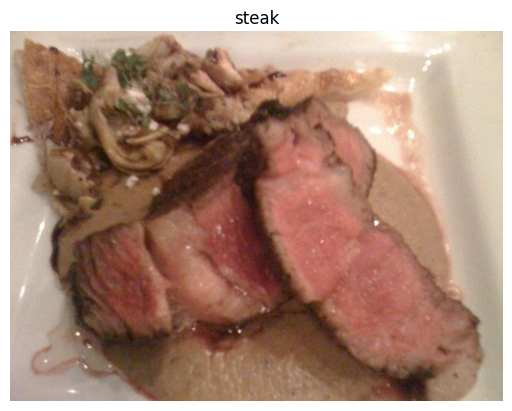

In [8]:
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt

image_list = list(Path(test_dir).glob("*/*.jpg"))
img_path = random.choice(image_list)
image,title = Image.open(img_path),img_path.parent.name,

plt.figure()
plt.imshow(image)
plt.axis(False)
plt.title(title)
plt.show()

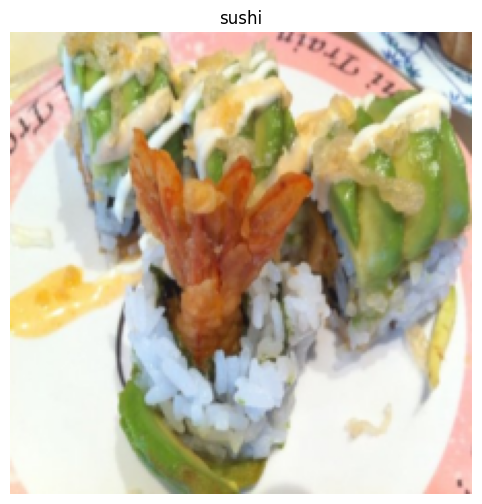

In [9]:
# another way to do this
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0],label_batch[0]

plt.figure(figsize=(10,6))
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

## replicating the VIT overview
this would be done by working with the pattern

**Inputs** - What goes into the model
check paper here : https://arxiv.org/pdf/2010.11929
**Reference Figures**:
#### Figure 1
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true" width=600 alt="Base transformer architecture"/>

*Architecture diagram of a target transformer block*

* Embedding = learnable representation (start with randonnumbers and imporve over time)







#### Figure 2
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true" width=600 alt="Base transformer architecture"/>

*Equation represntation of the block*

#### Section 3.1 describes the various equations
3.1 VISION TRANSFORMER (VIT)

**Equation 1:**
***
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
***
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2,...,image_patch_N] + [class_token_pos, image_patch_pos_1, image_patch_pos_2,...]
```



**Equation 2&3:**
***
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In Pseudocode

```python
#Equation 2
x_output_msa_block = MSA_layer(LN_layer(x_input)) + x_input

#Equation 3
x_output = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_msa_block

```




**Equation 4:**
***
Similar to BERT's [class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

MLP = multilayer perceptron = a neural network with X number of layers

MLP = one hidden layer at training time

MLP = single linear layer at fine-tuning time

In-pseudocode:
```python
 #Equation 4
 y = Linear_layer(LN_layer(x_output_MLP_block))
```







#### Table 1
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width=600 alt="Base transformer architecture"/>

* ViT-Base, ViT-Large and ViT-Huge are different sizes of the same model architecture
* Layers - The number of transformer encoder layers
* Hidden size $D$ - The enbedding size through the architecture
* MLP size - The number of hidden neurons in the MLP
* Heads - the number of multi-head self-attention


### splitting images into patches


In [10]:
height = 224
width=224
patch_size=16
color_channels=3
number_of_patches = int(height*width/patch_size**2)
number_of_patches

196

In [11]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 *color_channels)
embedding_layer_input_shape,embedding_layer_output_shape

((224, 224, 3), (196, 768))

(-0.5, 223.5, 223.5, -0.5)

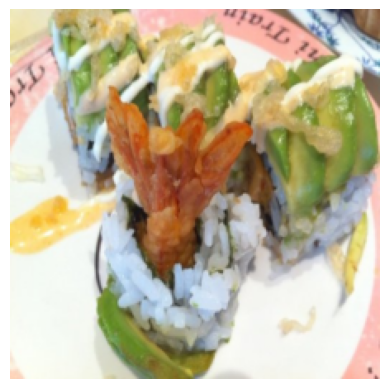

In [12]:
# visulaize
plt.imshow(image.permute(1,2,0))
plt.axis(False)

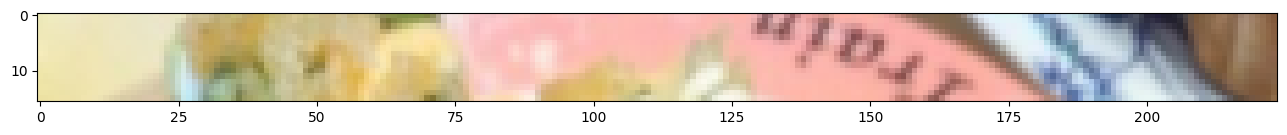

In [13]:
# get teh top row of the image
image_permute = image.permute(1,2,0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permute[:patch_size,:,:])


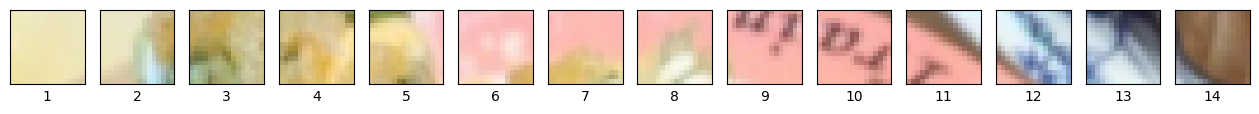

In [14]:
# plot data as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size ==0, "Image size must be dividible by patch size"

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(16,16))
# iterate through data in top plot and plot
for i, patch in enumerate(range(0,img_size, patch_size)):
  axs[i].imshow(image_permute[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


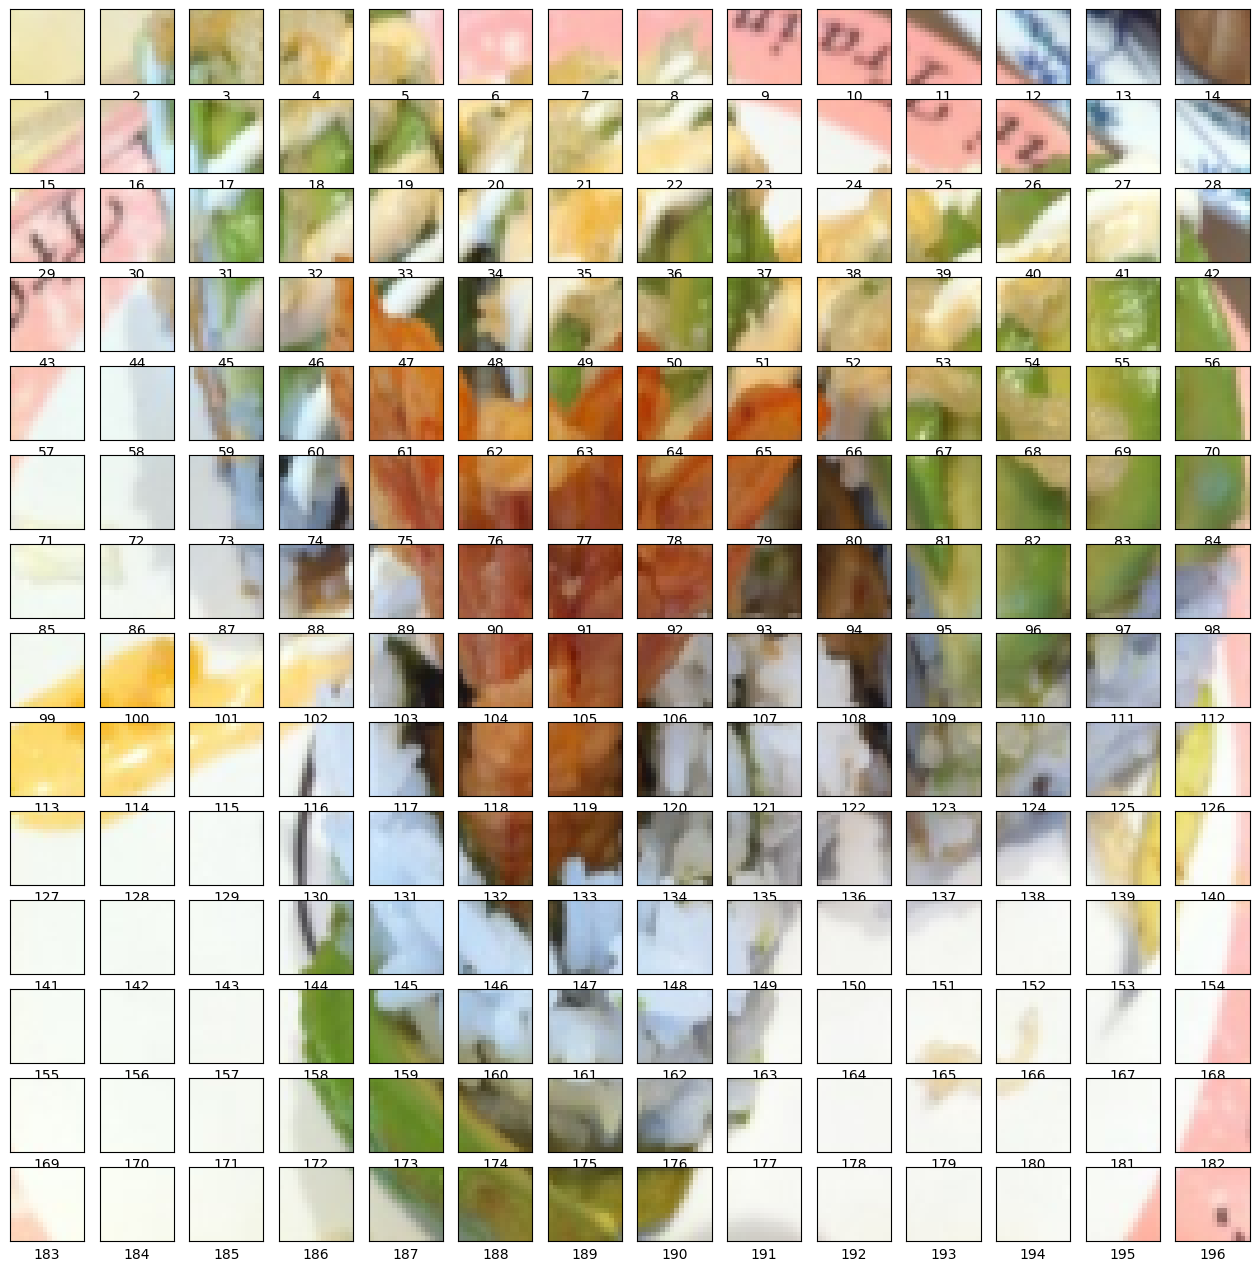

In [15]:
# plot data as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size ==0, "Image size must be dividible by patch size"

# create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(16,16))
# iterate through data in top plot and plot
k=1
for j ,patch_j in enumerate(range(0,img_size,patch_size)):
  for i, patch in enumerate(range(0,img_size, patch_size)):
    axs[j,i].imshow(image_permute[patch_j:patch_j+patch_size,patch:patch+patch_size,:])
    axs[j,i].set_xlabel(k)
    axs[j,i].set_xticks([])
    axs[j,i].set_yticks([])
    k+=1


In [16]:
# creating image patches using torch.nn.Conv2D and conver them to embeddings

from torch import nn

patch_size=16

conv_2d = nn.Conv2d(in_channels=3,
                    out_channels = 768,
                    kernel_size=patch_size,
                    stride=patch_size)
conv_2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

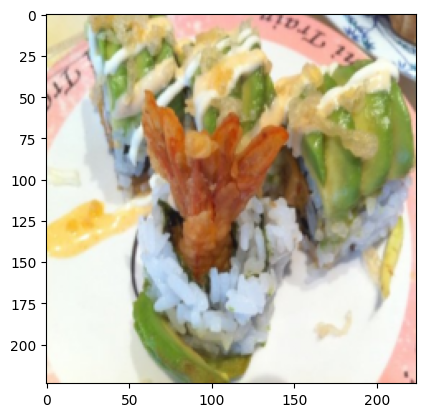

In [17]:
plt.imshow(image.permute(1,2,0))

In [18]:
# passing the image through the conv layer
image_out_of_conv = conv_2d(image.unsqueeze(0))
image_out_of_conv.shape


torch.Size([1, 768, 14, 14])

In [19]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image map (patches) shape: torch.Size([1, 768, 196])


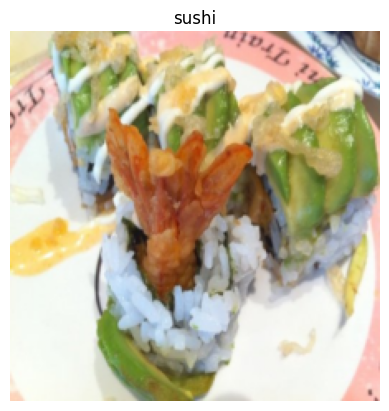

In [20]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

image_out_of_conv = conv_2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# flatten the feature maps
image_out_of_conv_flattebed = flatten_layer(image_out_of_conv)
print(f"Flattened image map (patches) shape: {image_out_of_conv_flattebed.shape}")

In [21]:
# rerrabege
image_out_of_conv_flattebed.permute(0,2,1).shape

torch.Size([1, 196, 768])

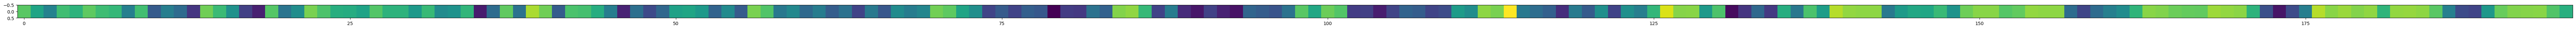

In [22]:
single_flatten_map = image_out_of_conv_flattebed.permute(0,2,1)[:,:,1]
plt.figure(figsize=(100,100))
plt.imshow(single_flatten_map.detach().numpy())

In [23]:
# turning patches into layers
class PatchEmbedding(nn.Module):
  def __init__(self,channels:int=3,embedding_dimension:int=768,patch_size:int=16):
    super().__init__()
    self.patch_size=patch_size
    self.patcher = nn.Sequential(
        nn.Conv2d(
            in_channels=channels,
            out_channels=embedding_dimension,
            kernel_size=patch_size,
            stride=patch_size
        ),
        nn.Flatten(start_dim=2,end_dim=3)
    )
  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size ==0, f"Input image must be divisibly by {patch_size}"
    return self.patcher(x).permute(0,2,1)


In [24]:
set_seeds()
# create instance of patch embedding
pachify = PatchEmbedding()
patch_embedded_image = pachify(image.unsqueeze(0))

In [25]:
# creating the class token embedding
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [26]:
# creating class token embedding as a lear
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension))
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

**Creating the positional embedding**

Want to: create a a seriens of 1D learnable positional embeddings and to add them to the sequence of patch embeddings.

In [27]:
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
          [-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
          [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
          ...,
          [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
          [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
          [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [28]:
# number pof patches
number_of_patches = int((height*width)/patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

positional_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,
                                               embedding_dimension),
                                    requires_grad=True)
positional_embedding, positional_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [29]:
patch_and_positional_embedding = patch_embedded_image_with_class_embedding+positional_embedding
patch_and_positional_embedding

tensor([[[ 1.5436,  0.5300, -0.2133,  ...,  0.5429,  1.4486,  1.1217],
         [ 0.0832,  1.2429,  0.7706,  ...,  1.6771,  0.5491,  1.3483],
         [ 0.2573,  1.1953,  0.6441,  ...,  1.5824,  0.6549,  1.3274],
         ...,
         [-0.0077,  1.2796,  0.7205,  ...,  1.7628,  0.5416,  1.3580],
         [ 0.0161,  1.1649,  0.8400,  ...,  1.7498,  0.4528,  1.3500],
         [ 0.0738,  1.1364,  0.8849,  ...,  1.5843,  0.5250,  1.3103]]],
       grad_fn=<AddBackward0>)

In [30]:
# from image to embedding
set_seeds()

patch_size=16
print(f"image tensor shape{image.shape}")
height, width = image.shape[1],image.shape[2]
x = image.unsqueeze(0)

patch_embedded_layer = PatchEmbedding(
    channels=3,
    patch_size=patch_size,
    embedding_dimension = 768
)
# pass input image through

patch_embedding = patch_embedded_layer(x)
print(f"Pach embedding shape:{patch_embedding.shape}")
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f"Class token embedding shape:{class_token.shape}")
# prepent the class token to the patch_embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding),dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape} ")
# creating the positional embeding
number_of_patches = int((height*width)/patch_size**2)
positional_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)

# adding
patch_and_positional_embedding = patch_embedding_class_token +positional_embedding
print(f"Patch and positional embeddings shape: {patch_and_positional_embedding.shape}")

image tensor shapetorch.Size([3, 224, 224])
Pach embedding shape:torch.Size([1, 196, 768])
Class token embedding shape:torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768]) 
Patch and positional embeddings shape: torch.Size([1, 197, 768])


In [31]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creating a Multi head self attenstion block"""
  def __init__(self, embedding_dim:int=768,
               num_heads:int = 12,
               att_dropout:int=0):
    super().__init__()
    self.layer_norm  = nn.LayerNorm(normalized_shape=embedding_dim)
    # MSA
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=att_dropout,
                                                batch_first=True
                                                )
  def forward(self, x):
    x = self.layer_norm(x)
    attrn_output,_ = self.multihead_attn(
          query=x,
          key=x,
          value=x,
          need_weights=False
    )
    return attrn_output



In [32]:
# testing MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock()
output = multihead_self_attention_block(patch_and_positional_embedding)
patch_and_positional_embedding.shape,output.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

#### Important data for equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layer(s). layers can be multiple or even only one hidden layer

  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for thesame thing. In Pytorch, they're often calles `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GELU in Pytorch - https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP number of hidden units = MLP Size in table 1
* **Dropout** =  Dropout, when used is applied after every dense layer except for the qkv-projections and directly after adding positional patch embedding. Hybrid models are trained with the excact setup as their ViT counterparts.
  * Value for dropout vailable in table 3 of the paper

In pseudocode ⁉

```python
  MLP
  x = Linear -> non-Linear -> dropout -> linear -> dropout

```



In [33]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim:int=768,
               num_heads:int = 12,
               mlp_size:int = 3072,
               dropout:float=0.1,

               ):
    super().__init__()
    self.layer_norm  = nn.LayerNorm(normalized_shape=embedding_dim)
    # building the MLP
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim,mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(mlp_size,embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    return self.mlp(self.layer_norm(x))




In [34]:
# creating an instance of the MLPBlock
mlp_block = MLPBlock()
patched_image_through_msa_block = mlp_block(output)
patched_image_through_msa_block,patched_image_through_msa_block.shape

(tensor([[[-0.0568, -0.0132,  0.1596,  ...,  0.0000, -0.1730,  0.1774],
          [-0.1111, -0.1196,  0.2626,  ..., -0.0520, -0.1367,  0.2218],
          [-0.0161, -0.0584,  0.2760,  ..., -0.0000, -0.2058,  0.2006],
          ...,
          [-0.2100, -0.0106,  0.2730,  ...,  0.1729, -0.2039,  0.2873],
          [-0.1370,  0.0425,  0.0000,  ...,  0.0974, -0.1918,  0.0845],
          [-0.0703, -0.0377,  0.2166,  ..., -0.0604, -0.1868,  0.1791]]],
        grad_fn=<MulBackward0>),
 torch.Size([1, 197, 768]))

#### Creating a custom transformer block

In [35]:
# creating the transformer encoder

class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()
    # creating MSA Block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 att_dropout=attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout
                              )
  def forward(self, x):
    x= self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x


In [36]:
transformer_encoder_block = TransformerEncoderBlock()
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [37]:
# trying to recreate what was created above with inbuilt libraries

torch_transformer = nn.TransformerEncoderLayer(d_model=768,
                                               nhead=12,
                                               dim_feedforward=3072,
                                               dropout=0.1,
                                               batch_first=True,
                                               norm_first=True)
torch_transformer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [38]:
summary(model=torch_transformer,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [39]:
# cteating a final transformer
class ViT(nn.Module):
  def __init__(self,
               image_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000):
    super().__init__()
    # make an assertion that
    assert image_size % patch_size ==0, f"Image size must be divisible by patch_size, image:{image_size}, patch size:{patch_size}"
    # number of patches
    self.num_patches = (image_size*image_size)//patch_size**2
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)
    # creating og thr positional embeddings
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
    # create embedding droupout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    #Create patch embedding layer
    self.patch_embedding = PatchEmbedding(
        channels=in_channels,
        patch_size=patch_size,
        embedding_dimension=embedding_dim
    )
    # creating the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(embedding_dim,num_classes)
    )
  def forward(self, x):
    batch_size = x.shape[0]
    # creating class token embedding
    class_token = self.class_embedding.expand(batch_size,-1,-1)
    # creating the patch embedding(paper eqn 1)
    x = self.patch_embedding(x)
    # concat class token embedding and patch embedding
    x = torch.cat((class_token,x),dim=1)
    # adding positional embedding to class token and patch embedding
    x = self.position_embedding + x
    # applying dropout
    x = self.embedding_dropout(x)
    #
    x = self.transformer_encoder(x)
    x = self.classifier(x[:,0])

    return x



In [40]:
set_seeds()

random_image_tensor = torch.randn(1,3,224,224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [41]:
from torchinfo import summary
summary(model=vit,
        input_size=random_image_tensor.shape,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Sequential (patcher)                                  [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten (1)                                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768] 

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vit.parameters(),betas=(0.9,0.999),weight_decay=0.1, lr=0.001)
from going_modular.going_modular import engine
result = engine.train(
    model=vit,
    train_dataloader = train_dataloader,
    test_dataloader=test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2935 | train_acc: 0.4609 | test_loss: 2.7705 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9914 | train_acc: 0.3906 | test_loss: 2.6003 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.6454 | train_acc: 0.2969 | test_loss: 1.0575 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2388 | train_acc: 0.4180 | test_loss: 1.4927 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1774 | train_acc: 0.2773 | test_loss: 1.4238 | test_acc: 0.2604


The poor results can be observed from the fact that the model in this case get a significantly small amount of data compared to what is required to train the *ViT* transformer

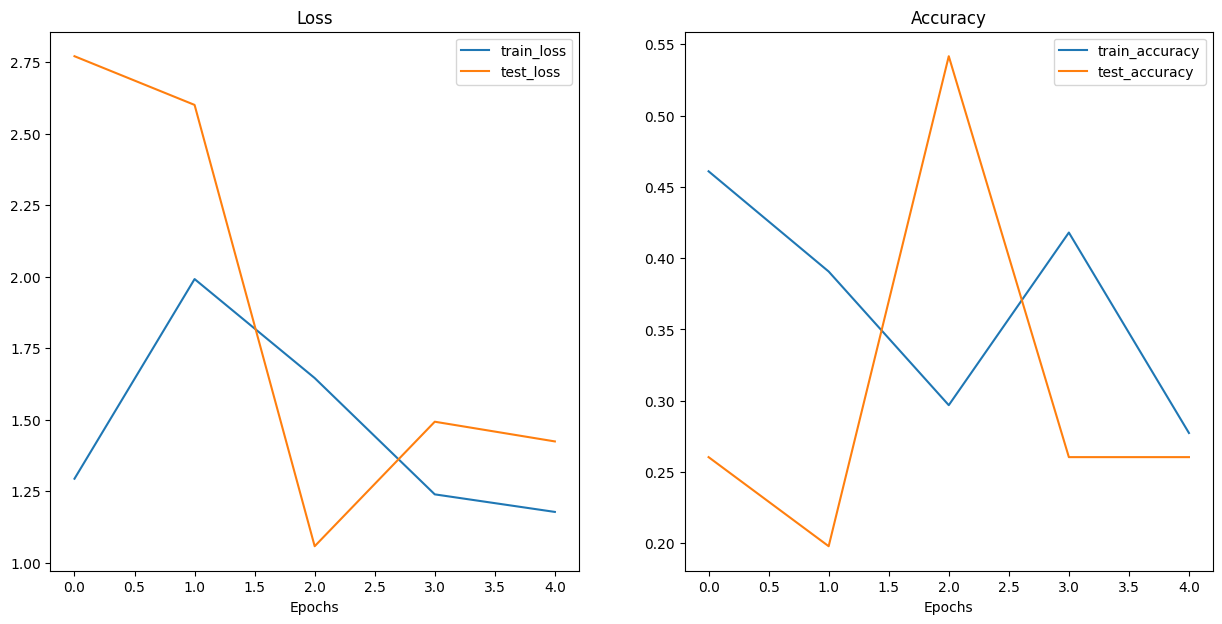

In [53]:
from helper_functions import plot_loss_curves
plot_loss_curves(result)

In [54]:
# pretrained ViT weights
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_model = torchvision.models.vit_b_16(weights=vit_weights).to(device)


In [55]:
# freezing the layers
for param in vit_model.parameters():
  param.requires_grad = False



In [56]:
vit_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [57]:
# creating the alternate heads
vit_model.heads =nn.Linear(in_features=768,out_features=3, bias=True).to(device)


In [58]:
summary(model=vit_model,
        input_size=random_image_tensor.shape,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [59]:
# loading the training and testing data
train_dataloader_v, test_dataloader_v, _ = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform = vit_weights.transforms(),
    batch_size=32
)

imgs, labels = next(iter(train_dataloader_v))
labels.shape, imgs.shape

(torch.Size([32]), torch.Size([32, 3, 224, 224]))

In [60]:
# visualize one image
image_v, label = imgs[0], labels[0]

In [61]:
set_seeds()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit_model.parameters(),lr=0.001)
result_tl = engine.train(
    model=vit_model,
    train_dataloader = train_dataloader_v,
    test_dataloader=test_dataloader_v,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6957 | train_acc: 0.8086 | test_loss: 0.4503 | test_acc: 0.8778
Epoch: 2 | train_loss: 0.3054 | train_acc: 0.9414 | test_loss: 0.3370 | test_acc: 0.8987
Epoch: 3 | train_loss: 0.2138 | train_acc: 0.9609 | test_loss: 0.2619 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.2113 | train_acc: 0.9688 | test_loss: 0.2402 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1390 | train_acc: 0.9688 | test_loss: 0.1819 | test_acc: 0.9384


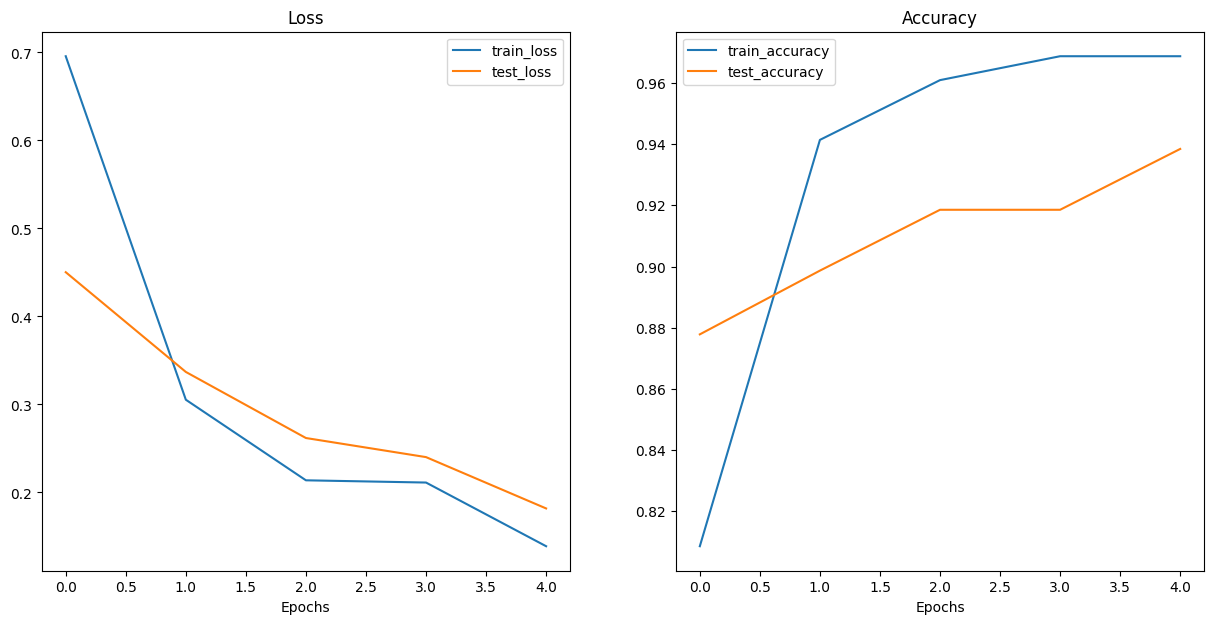

In [62]:
plot_loss_curves(result_tl)

In [66]:
# saving the best performing mode
from going_modular.going_modular import utils
# saving the model
model_name = "08_vit_pretrained.pth"
utils.save_model(
    model=vit_model,
    target_dir="models",
    model_name=model_name
)




[INFO] Saving model to: models/08_vit_pretrained.pth


In [69]:
from pathlib import Path
pretrained_vit_model = Path("models/08_vit_pretrained.pth").stat().st_size//(1024*1024)
print(f"pretrained_vit_model: {pretrained_vit_model}MB")

pretrained_vit_model: 327MB


(-0.5, 223.5, 223.5, -0.5)

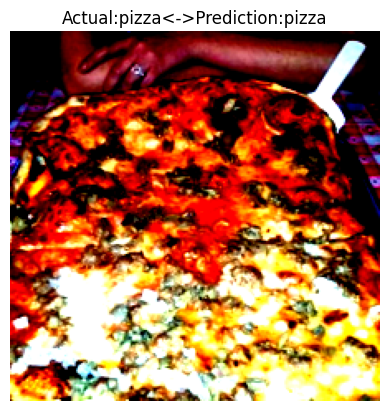

In [87]:
image_v, label = imgs[0], labels[0]
image_r = image_v.unsqueeze(dim=0)

logits = vit_model(image_r.to(device))
pred = torch.argmax(torch.softmax(logits,dim=1),dim=1).cpu().numpy()
plt.imshow(image_v.permute(1,2,0))
plt.title(f"Actual:{class_names[label]}<->Prediction:{class_names[pred[0]]}")
plt.axis(False)